<a href="https://colab.research.google.com/github/rebel747/BitcoinPrediction/blob/master/Deep%20Active%20contours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Layer, Conv1D, GlobalAveragePooling1D,
                                   Reshape, Flatten, Dense, LeakyReLU,
                                   Conv1DTranspose, UpSampling1D, Input,
                                   MaxPooling1D, BatchNormalization)
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Nadam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
!pip install tensorflow-addons

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

## Model Defination

##1-D Auto Encoder

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def load_and_preprocess_data_kfold(n_splits=5):
    # Load datasets
    df_pd = pd.read_csv("/content/circular_fm_new_pd_vs_swedd_V3 .csv")
    df_control = pd.read_csv("/content/circular_fm_new.csv")

    # Combine datasets
    df = df_control

    # Extract features and labels
    X = df.iloc[:, 2:26].values  # Adjust indices if needed
    y = df.iloc[:, 26].values

    # Normalize features
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Reshape for Conv1D
    X_reshaped = X_normalized.reshape(-1, X_normalized.shape[1], 1)

    # Create Stratified K-Folds
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    folds = []
    for train_idx, test_idx in skf.split(X_reshaped, y):
        X_train, X_test = X_reshaped[train_idx], X_reshaped[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        folds.append((X_train, X_test, y_train, y_test))

    return folds, scaler


In [ ]:
import tensorflow
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU

# Make sure DPHO_CRU is defined or imported above this
def build_autoencoder(input_shape):
    # Input
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(16, 5, padding='same')(input_layer)
    x = BatchNormalization()(x)  # Added batch normalization
    x = LeakyReLU(alpha=0.2)(x)
    layer1 = x

    x = MaxPooling1D(2)(x)
    layer2 = x

    x = Conv1D(8, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    layer3 = x

    bottleneck1 = Conv1D(1, 1, padding='same')(x)
    x = BatchNormalization()(x)
    bottleneck1 = LeakyReLU(alpha=0.2)(bottleneck1)
    layer4 = bottleneck1

    bottleneck2 = Conv1D(1, 1, padding='same')(bottleneck1)
    x = BatchNormalization()(x)
    bottleneck2 = LeakyReLU(alpha=0.2)(bottleneck2)
    layer5 = bottleneck2

    # Decoder
    x = Conv1DTranspose(8, 1, padding='same')(bottleneck2)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    layer6 = x

    x = Conv1DTranspose(16, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    layer7 = x

    x = UpSampling1D(2)(x)
    layer8 = x

    # Output layers
    reconstruction = Conv1DTranspose(1, 5, padding='same', activation='linear', name='reconstruction')(x)
    layer9 = reconstruction

    classification = Flatten()(bottleneck1)
    #from tensorflow.keras.layers import LeakyReLU

    classification = Dense(8)(classification)
    classification = BatchNormalization()(classification)
    classification = LeakyReLU(negative_slope=0.2)(classification)  # You can adjust alpha if needed





    classification = Dense(1, activation='sigmoid', name='classification')(classification)

    print(input_layer.shape)
    main_model = Model(
        inputs=input_layer,
        outputs=[reconstruction, classification],
        name="dual_output_autoencoder"
    )

    intermediate_model = Model(
        inputs=input_layer,
        outputs=[layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9],
        name="intermediate_layer_model"
    )

    return main_model, intermediate_model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.metrics import Metric
import tensorflow as tf

class F1Score(Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision = Precision(thresholds=self.threshold)
        self.recall = Recall(thresholds=self.threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred >= self.threshold, tf.float32)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(y):
    classes = np.unique(y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    return dict(zip(classes, weights))

def get_sample_weights(y, class_weights):
    return np.array([class_weights[cls] for cls in y])


In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Nadam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import AUC, Precision, Recall
import numpy as np
import matplotlib.pyplot as plt

# Define or import your F1Score here if it's a custom metric
# from your_metrics import F1Score

def get_sample_weights(y, class_weights):
    return np.array([class_weights[int(label)] for label in y])

def train_model(n_splits=5, epochs=52, batch_size=32):
    folds, scaler = load_and_preprocess_data_kfold(n_splits=n_splits)
    all_histories = []

    for i, (X_train, X_test, y_train, y_test) in enumerate(folds):
        print(f"\nTraining on Fold {i + 1}/{n_splits}...")

        main_model, intermediate_model = build_autoencoder(X_train.shape[1:])

        main_model.compile(
            optimizer=Nadam(learning_rate=1e-4),
            loss={
                'reconstruction': 'mse',
                'classification': 'binary_crossentropy'
            },
            loss_weights={
                'reconstruction': 0.1,
                'classification': 1.0
            },
            metrics={
                'reconstruction': ['mse', 'mae'],
                'classification': [
                    'accuracy',
                    AUC(name='auc'),
                    Precision(name='precision'),
                    Recall(name='recall'),
                    F1Score(name='f1_score')  # Make sure F1Score is defined
                ]
            }
        )


        history = main_model.fit(
            x=X_train,
            y={'reconstruction': X_train, 'classification': y_train},
            validation_data=(X_test, {'reconstruction': X_test, 'classification': y_test}),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
        all_histories.append(history.history)

    # Average metrics over folds per epoch
    avg_history = {}
    keys = all_histories[0].keys()

    for key in keys:
        values = [fold_hist[key] for fold_hist in all_histories if key in fold_hist]
        values = np.array(values)
        avg_history[key] = np.mean(values, axis=0)

    # --- Plot accuracy, precision, recall, f1 score on one graph ---
    plt.figure(figsize=(10, 6))
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    for metric in metrics:
        train_key = f'classification_{metric}'
        val_key = f'val_classification_{metric}'
        if train_key in avg_history:
            plt.plot(avg_history[train_key], label=f'Train {metric.capitalize()}')
        if val_key in avg_history:
            plt.plot(avg_history[val_key], label=f'Val {metric.capitalize()}')
    plt.title('Average Accuracy, Precision, Recall, and F1 Score vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot AUC separately ---
    plt.figure(figsize=(10, 6))
    if 'classification_auc' in avg_history:
        plt.plot(avg_history['classification_auc'], label='Train AUC')
    if 'val_classification_auc' in avg_history:
        plt.plot(avg_history['val_classification_auc'], label='Val AUC')
    plt.title('Average AUC vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print final average metrics
    # Compute and print average metrics (mean ± std) at final epoch
    print("\n=== Average Metrics at Final Epoch (Mean ± Std) ===")
    final_epoch_stats = {}

    for key in keys:
        values = [fold_hist[key][-1] for fold_hist in all_histories if key in fold_hist]
        if values:
            mean_val = np.mean(values)
            std_val = np.std(values)
            final_epoch_stats[key] = (mean_val, std_val)
            print(f"{key}: {mean_val:.4f} ± {std_val:.4f}")


    return main_model, avg_history, scaler, intermediate_model, X_train




Starting training...

Training on Fold 1/5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


(None, 24, 1)
Epoch 1/52
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 503ms/step - classification_accuracy: 0.5966 - classification_auc: 0.4099 - classification_f1_score: 0.7358 - classification_loss: 0.6718 - classification_precision: 0.8161 - classification_recall: 0.6699 - loss: 0.7721 - reconstruction_loss: 1.0030 - reconstruction_mae: 0.7966 - reconstruction_mse: 1.0032 - val_classification_accuracy: 0.6652 - val_classification_auc: 0.4354 - val_classification_f1_score: 0.7912 - val_classification_loss: 0.6853 - val_classification_precision: 0.8324 - val_classification_recall: 0.7539 - val_loss: 0.7810 - val_reconstruction_loss: 1.0043 - val_reconstruction_mae: 0.7748 - val_reconstruction_mse: 0.9738
Epoch 2/52
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - classification_accuracy: 0.6188 - classification_auc: 0.4619 - classification_f1_score: 0.7522 - classification_loss: 0.6540 - classification_precision: 0.8268 - classification_recall: 0.6900 - loss: 0.7466 - reconstruction_loss: 0.9253 - recons

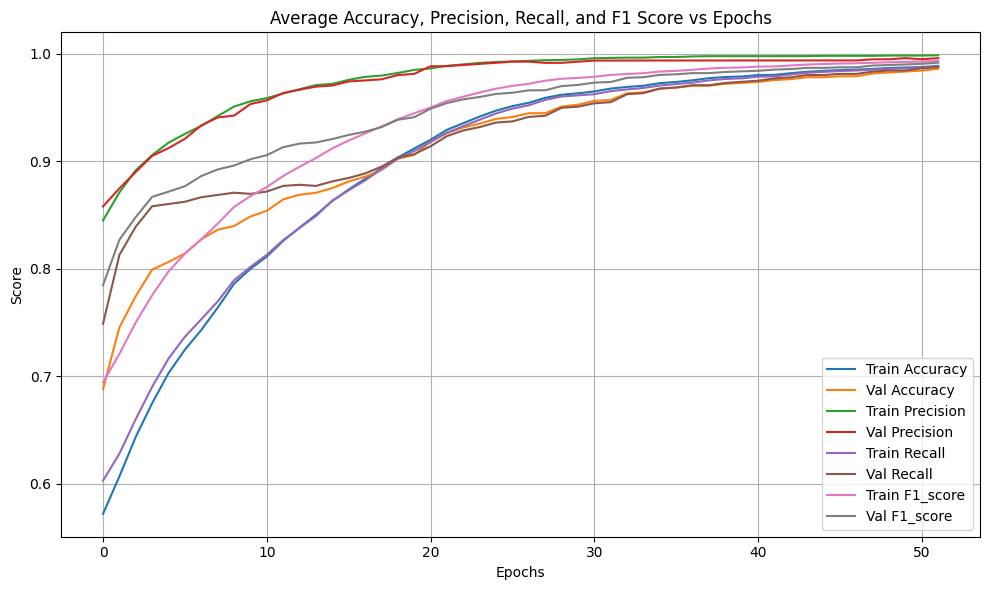

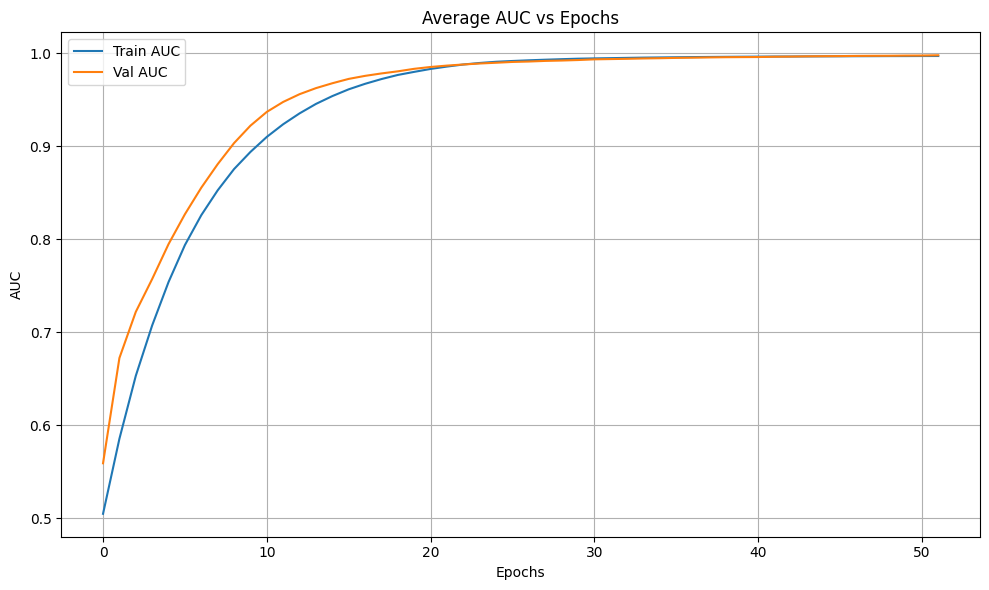


=== Average Metrics at Final Epoch (Mean ± Std) ===
classification_accuracy: 0.9885 ± 0.0116
classification_auc: 0.9972 ± 0.0055
classification_f1_score: 0.9931 ± 0.0070
classification_loss: 0.2163 ± 0.0457
classification_precision: 0.9984 ± 0.0026
classification_recall: 0.9879 ± 0.0114
loss: 0.2659 ± 0.0439
reconstruction_loss: 0.5102 ± 0.0884
reconstruction_mae: 0.5467 ± 0.0475
reconstruction_mse: 0.5102 ± 0.0891
val_classification_accuracy: 0.9859 ± 0.0129
val_classification_auc: 0.9980 ± 0.0036
val_classification_f1_score: 0.9915 ± 0.0078
val_classification_loss: 0.2007 ± 0.0383
val_classification_precision: 0.9958 ± 0.0052
val_classification_recall: 0.9874 ± 0.0127
val_loss: 0.2607 ± 0.0466
val_reconstruction_loss: 0.5149 ± 0.0540
val_reconstruction_mae: 0.5443 ± 0.0381
val_reconstruction_mse: 0.5036 ± 0.0718
Training completed!
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step


In [ ]:
print("Starting training...")
main_model, history, scaler, intermediate_model, X_train = train_model()
print("Training completed!")
intermediate_outputs = intermediate_model.predict(X_train)

In [ ]:
import tensorflow as tf

def correlation(tensor1, tensor2):
  """
  Calculates the Pearson correlation coefficient between two TensorFlow tensors.

  Args:
    tensor1: A TensorFlow tensor representing the first vector.
    tensor2: A TensorFlow tensor representing the second vector.

  Returns:
    A TensorFlow tensor representing the correlation coefficient.
  """
  # Ensure tensors have the same shape
  tensor1 = tf.reshape(tensor1, [-1])
  tensor2 = tf.reshape(tensor2, [-1])

  # Calculate mean-centered product and standard deviations
  cov = tf.reduce_mean((tensor1 - tf.reduce_mean(tensor1)) * (tensor2 - tf.reduce_mean(tensor2)))
  std1 = tf.sqrt(tf.reduce_mean(tensor1**2))
  std2 = tf.sqrt(tf.reduce_mean(tensor2**2))

  # Prevent division by zero
  tolerance = 1e-8
  correlation = tf.where(tf.abs(std1 * std2) > tolerance, cov / (std1 * std2), tf.constant(0.0))

  return correlation

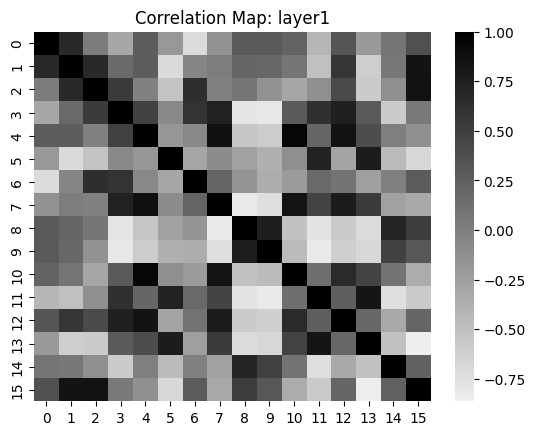

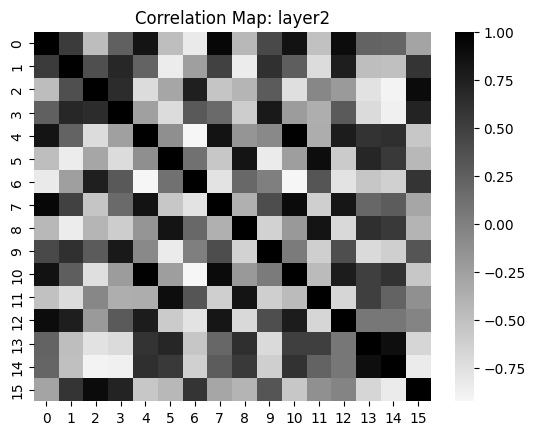

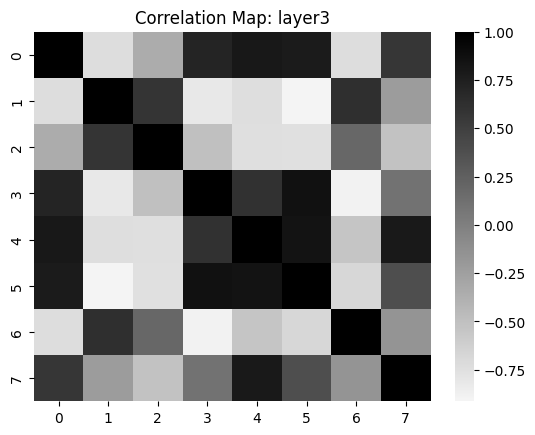

Skipping layer4 due to insufficient channels: shape = (12, 1)
Skipping layer5 due to insufficient channels: shape = (12, 1)


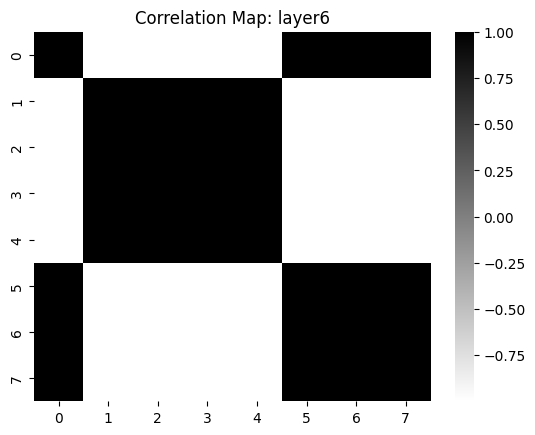

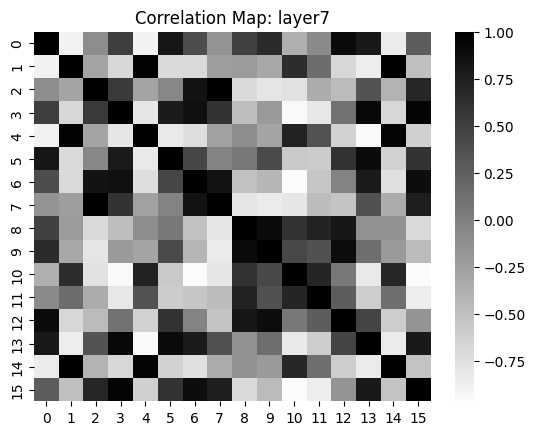

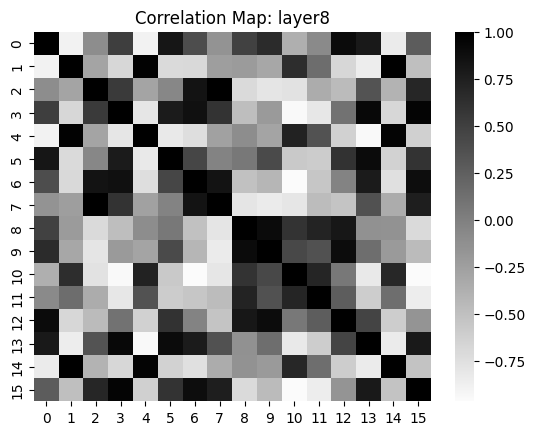

Skipping layer9 due to insufficient channels: shape = (24, 1)


In [ ]:
patient_idx = 100
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot correlation matrix
def plot_correlation_map(data, layer_name):
    corr = np.corrcoef(data, rowvar=False)
    sns.heatmap(corr, annot=False, cmap='gist_yarg', center=0)
    plt.title(f'Correlation Map: {layer_name}')
    plt.show()

# Plot correlation maps for each layer
layer_names = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8', 'layer9']
for layer_output, layer_name in zip(intermediate_outputs, layer_names):
    # Skip layers that are too small
    if layer_output[patient_idx].ndim < 2 or layer_output[patient_idx].shape[1] < 2:
        print(f"Skipping {layer_name} due to insufficient channels: shape = {layer_output[patient_idx].shape}")
        continue

    temp_layer_output = layer_output[patient_idx]
    num_channels = temp_layer_output.shape[1]
    corr_matrix = np.zeros((num_channels, num_channels))

    for i in range(num_channels):
        for j in range(num_channels):
            corr_matrix[i, j] = correlation(temp_layer_output[:, i], temp_layer_output[:, j])

    try:
        plot_correlation_map(corr_matrix, layer_name)
    except Exception as e:
        print(f"Error in {layer_name}: {e}")
        print(corr_matrix.shape)
